In [1]:
import os, time, random, einops, wandb, inspect
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image


import torch, torchaudio
import torch.nn as nn
import torchvision.io as tvio
import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode


import yaml
import decord
from worker.vaflow_sda_dit_noise_text_mel import VAFlow
from worker.dp_tts import DurationPredictor



def maxPathSumWithPath(matrix):
    m, n = len(matrix), len(matrix[0])
    dp = [[float('-inf')] * n for _ in range(m)]
    prev = [[None] * n for _ in range(m)]  # 记录前驱方向
    
    dp[0][0] = matrix[0][0]
    for j in range(1, n):
        dp[0][j] = dp[0][j-1] + matrix[0][j]
        prev[0][j] = 'left'
    for i in range(1, m):
        dp[i][0] = dp[i-1][0] + matrix[i][0]
        prev[i][0] = 'up'
    for i in range(1, m):
        for j in range(1, n):
            max_val = float('-inf')
            direction = None
            
            if i > 0 and dp[i-1][j] > max_val:
                max_val = dp[i-1][j]
                direction = 'up'
            if j > 0 and dp[i][j-1] > max_val:
                max_val = dp[i][j-1]
                direction = 'left'
            if i > 0 and j > 0 and dp[i-1][j-1] > max_val:
                max_val = dp[i-1][j-1]
                direction = 'diag'
            
            dp[i][j] = max_val + matrix[i][j]
            prev[i][j] = direction
    

    path = []
    i, j = m-1, n-1
    while i >= 0 and j >= 0:
        path.append((i, j))
        if prev[i][j] == 'up':
            i -= 1
        elif prev[i][j] == 'left':
            j -= 1
        elif prev[i][j] == 'diag':
            i -= 1
            j -= 1
        else:
            break 
    
    path.reverse()  
    return dp[m-1][n-1], path




def get_video_frames(
    va_path,
    video_process_config={'duration':10.0, 'resize_input_size': [224, 224], 'target_sampling_rate': 10, 'raw_duration_min_threshold':0.05},
    backend="decord",
):
    def check_and_drop(int_list, min_value, max_value):
        return [x for x in int_list if min_value <= x <= max_value]
    video_fram_h, video_frame_w = video_process_config['resize_input_size']
    clip_transform = transforms.Compose([
            transforms.Resize((video_fram_h, video_frame_w), interpolation=InterpolationMode.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
    ])
    video_process_config['target_frame_length'] = int(video_process_config['duration'] * video_process_config['target_sampling_rate'])

    if backend == "torchvision":
        try:
            frame_data, _, meta = tvio.read_video(va_path, pts_unit="sec", output_format="THWC")
            video_raw_fps = meta["video_fps"]
        except BaseException as e:
            raise e
        video_raw_frame_num = len(frame_data)
        video_raw_duration = video_raw_frame_num / video_raw_fps
        if video_raw_duration <= video_process_config['raw_duration_min_threshold']:
            raise RuntimeError(f"Video duration {video_raw_duration} is too short, less than {video_process_config['raw_duration_min_threshold']}.")
        video_sampled_frame_ids = [
            round(i * video_raw_fps / video_process_config['target_sampling_rate'])
            for i in range(video_process_config['target_frame_length'])
        ]
        video_sampled_frame_ids = check_and_drop(video_sampled_frame_ids, 0, video_raw_frame_num-1)
        sampled_frames = frame_data[video_sampled_frame_ids, :, :, :]
        if sampled_frames.dtype != torch.uint8:
            if sampled_frames.max() <= 1.0:
                sampled_frames = (sampled_frames * 255).byte()
            else:
                sampled_frames = sampled_frames.byte()
        sampled_frames = [Image.fromarray(frame.numpy()) for frame in sampled_frames]
    elif backend == "decord":
        try:
            decord_vr = decord.VideoReader(va_path, num_threads=1, ctx=decord.cpu(0))
        except BaseException as e:
            raise e
        video_raw_frame_num = len(decord_vr)
        video_raw_fps = decord_vr.get_avg_fps()
        video_raw_duration = video_raw_frame_num / video_raw_fps
        if video_raw_duration <= video_process_config['raw_duration_min_threshold']:
            raise RuntimeError(f"Video duration {video_raw_duration} is too short, less than {video_process_config['raw_duration_min_threshold']}.")
            
        # Sample frames with target sampling rate, 
        # NOTE Implemention of `FPS`` here is just selecting frames in raw 30fps video frames
        video_sampled_frame_ids = [ round(i * video_raw_fps / video_process_config['target_sampling_rate'])
                                    for i in range(video_process_config['target_frame_length']) ]
        video_sampled_frame_ids = check_and_drop(video_sampled_frame_ids, 0, video_raw_frame_num-1)
        sampled_frames = decord_vr.get_batch(video_sampled_frame_ids).asnumpy()
            
        if sampled_frames.dtype != np.uint8:
            if sampled_frames.max() <= 1.0:
                sampled_frames = (sampled_frames * 255).astype(np.uint8)
            else:
                sampled_frames = sampled_frames.astype(np.uint8)
            
        sampled_frames = [Image.fromarray(frame) for frame in sampled_frames]

    else:
        raise NotImplementedError(f"Backend `{backend}` is not implemented.")

    ''' Process frames '''
    p = video_process_config['target_frame_length'] - len(sampled_frames)
    if p > 0:
        w, h = sampled_frames[0].size  
        blank_pil = Image.new('RGB', (h, w), (0, 0, 0))
        sampled_frames = sampled_frames + [blank_pil] * p
    else:
        sampled_frames = sampled_frames[0 : video_process_config['target_frame_length']]
    assert len(sampled_frames) == video_process_config['target_frame_length'], f"Sampled frames length {len(sampled_frames)} is not equal to target length {self.video_target_frame_len}."
    # Transform and stack
    sampled_frames = [clip_transform(sampled_frame) for sampled_frame in sampled_frames ]
    processed_frames = torch.stack(sampled_frames, dim=0)
    return processed_frames


# va_paths = ['/home/chengxin/chengxin/Dataset_Sound/WVGGSound/dataset/test/10/__2MwJ2uHu0_000004.mp4']
# video_process_config = {'duration':10.0, 'resize_input_size': [224, 224], 'target_sampling_rate': 10, 'raw_duration_min_threshold':0.05}
# video_frames = [get_video_frames(va_path = va_path, video_process_config = video_process_config) for va_path in va_paths]
# len(video_frames), video_frames[0].shape, video_frames[0][0][0][0][195]


/home/chengxin/chengxin/anaconda3/envs/vaflow/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda:0'


with open('/home/chengxin/chengxin/vasflow/config/mode_vaflow.yaml', 'r') as f:
    vaflow_config = yaml.safe_load(f)
vaflow = VAFlow(**vaflow_config).to(device)


with open('/home/chengxin/chengxin/vasflow/config/model_dp.yaml', 'r') as f:
    dp_config = yaml.safe_load(f)
dp = DurationPredictor(**dp_config).to(device)


Some weights of the model checkpoint at /home/chengxin/chengxin/vasflow/model/stable_audio/ckpt/transformer_text were not used when initializing StableAudioDiTModel: ['transformer_blocks.22.attn1.to_q.weight', 'transformer_blocks.17.attn1.to_k.weight', 'transformer_blocks.14.attn1.to_k.weight', 'transformer_blocks.10.attn1.to_out.0.weight', 'transformer_blocks.21.ff.net.2.bias', 'transformer_blocks.17.attn2.to_q.weight', 'transformer_blocks.21.norm2.bias', 'transformer_blocks.15.norm1.weight', 'transformer_blocks.12.attn1.to_out.0.weight', 'transformer_blocks.10.ff.net.0.proj.bias', 'transformer_blocks.21.attn2.to_k.weight', 'transformer_blocks.18.norm2.weight', 'transformer_blocks.12.attn2.to_k.weight', 'transformer_blocks.13.attn2.to_v.weight', 'transformer_blocks.10.norm2.bias', 'transformer_blocks.19.attn2.to_k.weight', 'transformer_blocks.10.ff.net.2.bias', 'transformer_blocks.21.norm3.weight', 'transformer_blocks.23.norm3.weight', 'transformer_blocks.21.attn2.to_out.0.weight', 't

=> Restored vaflow ckpt from ./log/2025_05_13-11_58_33-vaflow_sda_dit_noise_text_mel_10l_cc_first10/ckpt/epoch=0129-step=2.27e+05.ckpt
=> Deleting key dp.phone_encoder.positial_embedding_q.pe from state_dict.
=> Deleting key dp.hubert_encoder.positial_embedding_q.pe from state_dict.
=> Deleting key dp.attn_decoder.positial_embedding_q.pe from state_dict.
=> Deleting key dp.attn_decoder.positial_embedding_kv.pe from state_dict.
=> Restored vaflow ckpt from /home/chengxin/chengxin/vasflow/log/2025_07_13-03_48_53-dp_tts_Lattn/ckpt/epoch=0319-step=1.31e+05.ckpt


In [ ]:
import torch
import numpy as np

def phonemes_to_token_ids(phoneme_seq, config_path='/home/chengxin/chengxin/Dataset_Sound/MetaData/vaflow2_meta/meta/token_list.json'):
    with open(config_path, 'r') as f:
        phoneme2id = yaml.safe_load(f)
    token_ids = [phoneme2id.get(p, phoneme2id.get('<unk>', 0)) for p in phoneme_seq]
    return torch.tensor(token_ids, dtype=torch.long)


# def pad_sequence(sequences, batch_first=False, padding_value=0, max_size = 250):
#     # sequences: list of torch.Tensor with shape [seq_len, ...]
#     max_size = sequences[0].size()
#     print(max_size)
#     trailing_dims = max_size[1:]
#     max_len = max([s.size(0) for s in sequences])
#     if batch_first:
#         out_dims = (len(sequences), max_len) + trailing_dims
#     else:
#         out_dims = (max_len, len(sequences)) + trailing_dims

#     out_tensor = sequences[0].new_full(out_dims, padding_value)
#     for i, tensor in enumerate(sequences):
#         length = tensor.size(0)
#         # use index notation to prevent duplicate references to the tensor
#         if batch_first:
#             out_tensor[i, :length, ...] = tensor
#         else:
#             out_tensor[:length, i, ...] = tensor
#     return out_tensor

def pad_sequence(sequences, padding_value=0, max_length=None, pad_type='right', target_dim=None):
    if not sequences:
        raise ValueError("sequences should not be empty")

    # Determine which dimension to pad (default: 0)
    if target_dim is None:
        target_dim = 0

    # Find max length
    lengths = [s.shape[target_dim] for s in sequences]
    pad_len = max(lengths) if max_length is None else max_length


    # Pad each tensor
    padded = []
    for s in sequences:
        pad_size = pad_len - s.shape[target_dim]
        if pad_size < 0:
            raise ValueError("Some sequence is longer than pad_len")
        pad_shape = [0] * (2 * s.dim())
        pad_shape[2 * (s.dim() - target_dim) - 1] = pad_size  # pad right
        if pad_type == 'left':
            pad_shape[2 * (s.dim() - target_dim) - 2] = pad_size  # pad left
            pad_shape[2 * (s.dim() - target_dim) - 1] = 0
        s_padded = torch.nn.functional.pad(s, pad_shape, mode='constant', value=padding_value)
        padded.append(s_padded)
    return torch.stack(padded, dim=0)





phoneme_seqs = ['<blank> S OW1 L EH1 T S T AO1 K AH0 B AW1 T AH0 B Z AO1 R P SH AH0 N AH1 V L AY1 T <blank>', '<blank> S OW1 L EH1 T S T AO1 K AH0 B AW1 T AH0 B Z AO1 R P SH AH0 N AH1 V T <blank>']
phoneme_seqs = [phoneme_seq.split(" ") for phoneme_seq in phoneme_seqs]
avhubert_feature_paths = None
speech_durations=[1.6, 1.6]
device="cuda:0"

# Convert phoneme sequences to token ids and pad
token_ids = [phonemes_to_token_ids(seq) for seq in phoneme_seqs]
phone_id = pad_sequence(token_ids, padding_value=0).to(device)  # [B, max_seq_len]
print(phone_id.shape)
phone_length = torch.tensor([len(seq) for seq in token_ids], dtype=torch.long, device=device)  # [B]

# Prepare avhubert features and pad
avhubert_list = []
avhubert_length = []
if avhubert_feature_paths is not None:
    for path in avhubert_feature_paths:
        feat = torch.tensor(np.load(path), device=device)
        avhubert_list.append(feat)
        avhubert_length.append(feat.shape[0])
else:
    assert speech_durations is not None
    for dur in speech_durations:
        feat = torch.ones(int(25 * dur), 1024, device=device)
        avhubert_list.append(feat)
        avhubert_length.append(feat.shape[0])
avhubert = pad_sequence(avhubert_list, padding_value=0.0, max_length = 250)  # [B, max_avhubert_len, 1024]
avhubert_length = torch.tensor(avhubert_length, dtype=torch.long, device=device)  # [B]

batch = {
    "video_id": None,
    "duration_matrix": None,
    "duration_span": None,
    "avhubert": avhubert,
    "avhubert_length": avhubert_length,
    "phone_id": phone_id,
    "phone_length": phone_length,
}


attns = dp.predict_step(batch)
attns.shape

torch.Size([2, 29])


torch.Size([2, 250, 29])

In [20]:
avhubert.shape

torch.Size([2, 250, 1024])

In [ ]:
for i in range(attns.shape[0]):
    max_sum, path = maxPathSumWithPath(attns[i]-1)
    attn = torch.zeros_like(attns[i])
    for p in path:
        attn[p[0], p[1]] = 1
    attn[avhubert_length[i]:] = 0
    attns[i] = attn

torch.Size([250, 29])
torch.Size([250, 29])


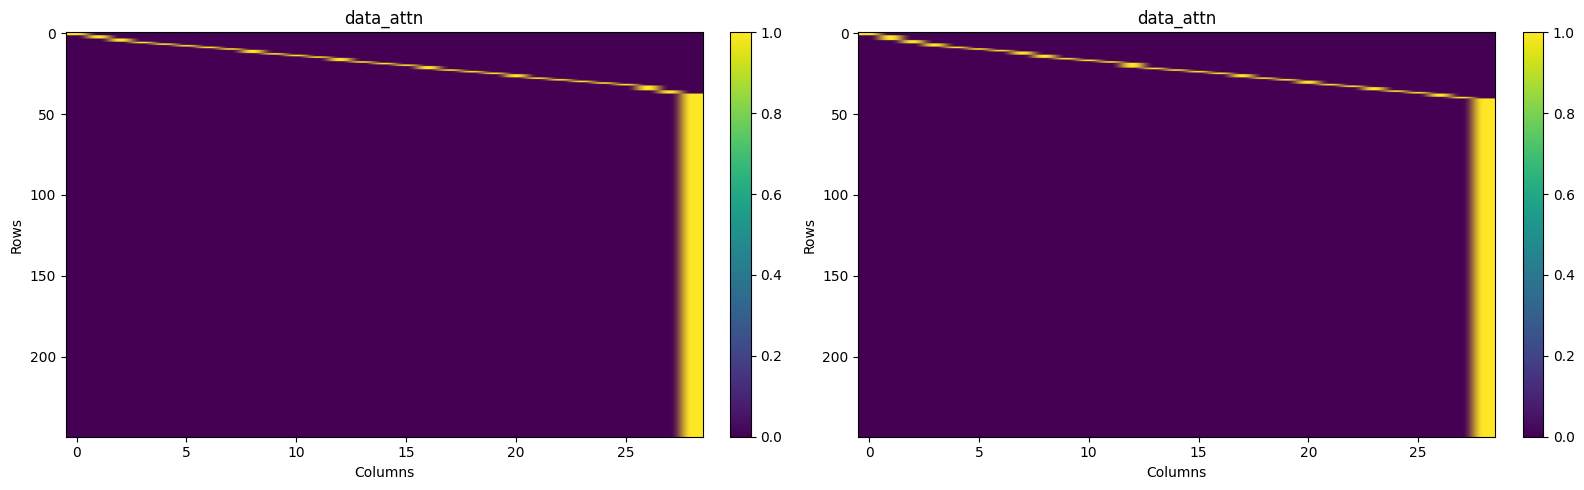

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

axs[0].imshow(attns[0].cpu().detach(), aspect='auto', cmap='viridis')
axs[0].set_title('data_attn')
axs[0].set_xlabel('Columns')
axs[0].set_ylabel('Rows')
plt.colorbar(axs[0].images[0], ax=axs[0], fraction=0.046, pad=0.04)

axs[1].imshow(attns[1].cpu().detach(), aspect='auto', cmap='viridis')
axs[1].set_title('data_attn')
axs[1].set_xlabel('Columns')
axs[1].set_ylabel('Rows')
plt.colorbar(axs[1].images[0], ax=axs[1], fraction=0.046, pad=0.04)


plt.tight_layout()
plt.show()



In [85]:
import torch.nn.functional as F
def adjust_speech(speech_start_duration, phone_id, duration_matrix, device):
    # phone_id [phone_length]    duration_matrix [250, phone_length]
    # phone_id = torch.cat((torch.tensor([59]).to(phone_id), phone_id))
    if speech_start_duration == 0:
        return torch.cat((torch.tensor([0], dtype=torch.int).to(phone_id), phone_id)), \
                torch.cat([duration_matrix, torch.zeros([250 ,1]).to(duration_matrix)], dim = -1)
    
    
    assert phone_id[0] == 59
    phone_id = torch.cat((torch.tensor([0], dtype=torch.int).to(phone_id), phone_id))            # [1 + phone_length]
    silence_length = int(round(speech_start_duration*25, 0))
    duration_matrix_new = torch.zeros([silence_length, phone_id.shape[-1]], device=device)     # [append_dur_length, 1 + phone_length]
    duration_matrix_new[:, 0] = 1

    assert duration_matrix[-silence_length].sum() == 0
    duration_matrix = duration_matrix[:-silence_length]                              # [250 - append_dur_length, phone_length]
    duration_matrix = F.pad(duration_matrix, (1, 0), mode='constant', value=0)       # [250 - append_dur_length, 1 + phone_length]
    duration_matrix_new = torch.cat((duration_matrix_new, duration_matrix), dim=0)   # [250, 1 + phone_length]
    return phone_id, duration_matrix_new

In [88]:

def infer_videos(vaflow_model, 
                 dp_model,
                save_path: str,
                mp4_paths:list[str], 
                video_process_config = {'duration':10.0, 'resize_input_size': [224, 224], 'target_sampling_rate': 10, 'raw_duration_min_threshold':0.05},
                phoneme_seqs = None,
                avhubert_feature_paths = None,
                speech_durations = None,
                speech_start_durations = None,
                ref_audio_ebd_paths = None,
                device="cuda"):
    vaflow_model.to(device)
    dp_model.to(device)
    batchsize = len(mp4_paths)



    # SPEECH PHONEMES
    phone_id = torch.zeros(len(mp4_paths), 1, dtype=torch.long, device=device)
    duration_matrix = torch.zeros(len(mp4_paths), vaflow_model.latent_length, phone_id.shape[-1], device=device)
    ref_audio_ebd = torch.zeros(len(mp4_paths), 256, device=device)
    if ref_audio_ebd_paths is not None:
        ref_audio_ebd = torch.stack([torch.tensor(np.load(path)).to(device) for path in ref_audio_ebd_paths])
    if phoneme_seqs is not None:
        token_ids = [phonemes_to_token_ids(seq) for seq in phoneme_seqs]
        phone_id = pad_sequence(token_ids, padding_value=0).to(device)  # [B, max_seq_len]
        phone_length = torch.tensor([len(seq) for seq in token_ids], dtype=torch.long, device=device)  # [B]

        # Prepare avhubert features and pad
        avhubert_list = []
        avhubert_length = []
        if avhubert_feature_paths is not None:
            for path in avhubert_feature_paths:
                feat = torch.tensor(np.load(path), device=device)
                avhubert_list.append(feat)
                avhubert_length.append(feat.shape[0])
        else:
            assert speech_durations is not None
            for dur in speech_durations:
                feat = torch.ones(int(25 * dur), 1024, device=device)
                avhubert_list.append(feat)
                avhubert_length.append(feat.shape[0])

        avhubert = pad_sequence(avhubert_list, padding_value=0.0, max_length = 250)  # [B, max_avhubert_len, 1024]
        avhubert_length = torch.tensor(avhubert_length, dtype=torch.long, device=device)  # [B]
        batch = {
            "video_id": None,
            "duration_matrix": None,
            "duration_span": None,
            "avhubert": avhubert,
            "avhubert_length": avhubert_length,
            "phone_id": phone_id,
            "phone_length": phone_length,
        }
        attns = dp.predict_step(batch)
        print(attns.shape)

        for i in range(attns.shape[0]):
            max_sum, path = maxPathSumWithPath(attns[i]-1)
            attn = torch.zeros_like(attns[i])
            for p in path:
                attn[p[0], p[1]] = 1
            attn[int(avhubert_length[i]):] = 0
            attns[i] = attn
        
        duration_matrix = attns
        if speech_start_durations is not None:
            new_phone_ids = torch.cat([phone_id, torch.zeros([batchsize,1]).to(phone_id)], dim = -1)
            new_duration_matrixs = torch.cat([duration_matrix, torch.zeros([batchsize, 250 ,1]).to(duration_matrix)], dim = -1)
            for i in range(duration_matrix.shape[0]):
                new_phone_id, new_duration_matrix = adjust_speech(speech_start_durations[i], phone_id[i], duration_matrix[i], device)
                print(phone_id.shape, new_phone_id.shape, duration_matrix.shape, new_duration_matrix.shape)
                new_phone_ids[i] = new_phone_id
                new_duration_matrixs[i] = new_duration_matrix
            phone_id = new_phone_ids
            duration_matrix = new_duration_matrixs

    # VIDEO FRAMES
    video_frames_list = []
    video_ids = []
    for path in mp4_paths:
        frames = get_video_frames(path, video_process_config)
        video_frames_list.append(frames)
        video_ids.append(os.path.basename(path).split('.')[0])
    video_frames_batch = torch.stack(video_frames_list, dim=0).to(device)  # [B, F, C, H, W]
    with torch.no_grad():
        video_features = vaflow_model.encode_image(video_frames_batch)  # [B, F, C]


    video_features = torch.zeros_like(video_features).to(video_features)
    batch = {
        "video_feat": video_features,
        "video_id": video_ids,
        "video_path": mp4_paths,
        "ref_audio_ebd": ref_audio_ebd,                                      # NOT IMPLEMENETED
        "audio_waveform": torch.zeros(len(mp4_paths), 1, vaflow_model.audio_sample_rate * 10, device=device),  # Dont Need
        "audio_sr": [16000] * len(mp4_paths),
        "audio_duration": [10.0] * len(mp4_paths),
        "duration_matrix": duration_matrix,  
        "phone_id": phone_id,                   
        "phone_seq": phoneme_seqs,                                                      
    }
    os.makedirs(save_path, exist_ok=True)
    vaflow_model.val_log_dir_for_video_per_epoch = save_path
    vaflow_model.validation_step(batch, batch_idx=0, dataloader_idx=0)
    # print(torch.bmm(duration_matrix , phone_id.unsqueeze(-1).to(torch.float32)))


va_paths = ['/home/chengxin/chengxin/Dataset_Sound/LRS2/video_25fps/6330311066473698535_27418/6330311066473698535_27418_00000.mp4']
phoneme_seqs = ['<blank> AH0 N D <blank> F AO1 R M IY1 <blank> DH AH0 S ER0 P R AY1 Z W AA1 Z <blank>']
phoneme_seqs = [phoneme_seq.split(" ") for phoneme_seq in phoneme_seqs]
speech_start_durations = None #[0]
video_process_config = {'duration':10.0, 'resize_input_size': [224, 224], 'target_sampling_rate': 10, 'raw_duration_min_threshold':0.05}

# 可以没有。speech_durations和avhubert_feature_paths只需要有一个
speech_durations = [2.5]
avhubert_feature_paths = ['/nfs-04/yuyue/visualtts_datasets/lrs2/lrs2_for_espnet/preprocessed_data/lip_feature/6330311066473698535_27418_00000.npy']
ref_audio_ebd_paths = ['/home/chengxin/chengxin/Dataset_Sound/LRS2/speaker_emb/6330311066473698535_27418/6330311066473698535_27418_00000.npy']


infer_videos(vaflow_model = vaflow, 
             dp_model = dp,
             save_path='./test', 
             mp4_paths=va_paths, 
             video_process_config = video_process_config, 
             phoneme_seqs = phoneme_seqs,
             avhubert_feature_paths = avhubert_feature_paths,
             speech_durations=speech_durations,
             speech_start_durations=speech_start_durations,
             ref_audio_ebd_paths = ref_audio_ebd_paths,
             device=device)

torch.Size([1, 250, 23])


In [55]:
wav, sr = torchaudio.load('/home/chengxin/chengxin/vasflow/test/6330311066473698535_27418_00000.mp4')
wav.shape, sr, wav.shape[-1]/sr

(torch.Size([1, 39936]), 16000, 2.496)

torch.Size([2, 29])

In [9]:
phoneme_seqs = ['<blank> S OW1 L EH1 T S T AO1 K AH0 B AW1 T AH0 B Z AO1 R P SH AH0 N AH1 V L AY1 T <blank>']
phoneme_seqs = [phoneme_seq.split(" ") for phoneme_seq in phoneme_seqs]

In [8]:
for phoneme_seq in phoneme_seqs:
    print(phoneme_seq)

['<blank> S OW1 L EH1 T S T AO1 K AH0 B AW1 T AH0 B Z AO1 R P SH AH0 N AH1 V L AY1 T <blank>']
